# Coordinate Transform Tutorial for UAV Nadir Imagery
## Converting Between Pixel and Real-World Coordinates for Aerial Footage

This tutorial demonstrates how to use the `coordinate_transform` module to process aerial imagery taken from a UAV (drone) in nadir view (camera pointing straight down). In this scenario, the relationship between pixel and real-world coordinates is relatively straightforward due to the overhead perspective.

What you'll learn:
- How to convert UAV image pixels to real-world coordinates
- How to establish scale using ground reference points
- How to handle basic geometric transformations for overhead imagery
- How to validate your coordinate transformations

### When to use this approach:
- Processing drone footage taken from directly above
- Working with relatively flat surfaces
- When the camera is approximately perpendicular to the ground
- When perspective distortion is minimal

### Setup
First, let's import the required libraries and set up our environment:

In [20]:
# Import required libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Set up path to the coordinate_transform module
import sys
sys.path.append('/Users/antoine/river/river/core')
import coordinate_transform as ct

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

## Setting up Reference Points and Initial Visualization

In this section, we'll establish our reference points for coordinate transformation. We need two sets of corresponding points:
1. Points in pixel coordinates (from our image)
2. The same points in real-world coordinates (measured in the field)

These points will help us establish the relationship between pixel space and real-world space.

(-0.5, 3839.5, 2159.5, -0.5)

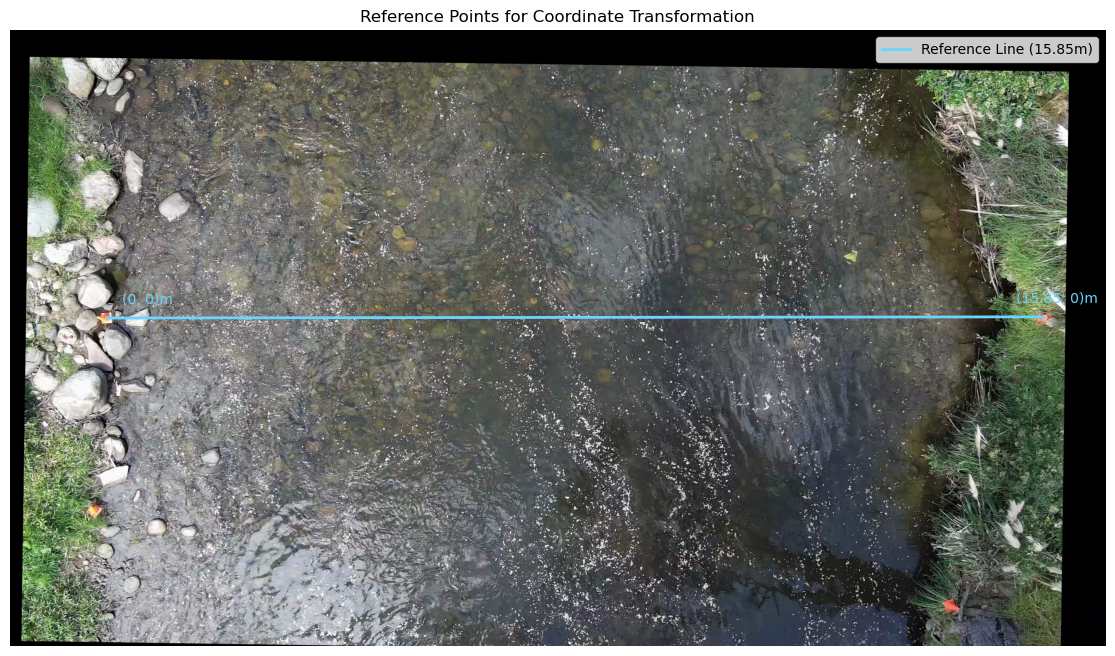

In [9]:
# Define reference points
# Point 1: Origin in both coordinate systems
x1_pix, y1_pix = 343.4, 1009.2   # Pixel coordinates of first point
x1_rw, y1_rw = 0, 0              # Real-world coordinates of first point (origin)

# Point 2: Second reference point
x2_pix, y2_pix = 3626.1, 1005.31 # Pixel coordinates of second point
x2_rw, y2_rw = 15.85, 0          # Real-world coordinates of second point (15.85 meters from origin)

# Load and display the image
img = plt.imread("frames/0000004980.jpg")
plt.figure(figsize=(15, 8))
plt.imshow(img)

# Plot the reference line connecting our two points
plt.plot([x1_pix, x2_pix], [y1_pix, y2_pix], 
         color='#6CD4FF', 
         linewidth=2, 
         label='Reference Line (15.85m)')

# Add annotations for better visualization
plt.annotate(f'(0, 0)m', (x1_pix, y1_pix), xytext=(10, 10), color='#6CD4FF',textcoords='offset points')
plt.annotate(f'(15.85, 0)m', (x2_pix, y2_pix), xytext=(-20, 10), color='#6CD4FF', textcoords='offset points')

plt.title('Reference Points for Coordinate Transformation')
plt.legend()
plt.axis('off')

## Calculating Pixel Size in Real-World Units

An essential step in coordinate transformation is determining how large each pixel is in real-world units (meters in our case). We'll use the `get_pixel_size` function from our coordinate transform module to calculate this.

The function works by:
1. Calculating the distance between two points in pixels
2. Comparing it to the known real-world distance
3. Computing the ratio to determine how many meters one pixel represents

In [10]:
# Calculate the pixel size using our reference points
pixel_size = ct.get_pixel_size(
    x1_pix=x1_pix, y1_pix=y1_pix,  # First point in pixels
    x2_pix=x2_pix, y2_pix=y2_pix,  # Second point in pixels
    x1_rw=x1_rw, y1_rw=y1_rw,      # First point in real-world coordinates
    x2_rw=x2_rw, y2_rw=y2_rw       # Second point in real-world coordinates
)

# Display the result with context
print(f"Pixel size: {pixel_size:.6f} meters/pixel")

# Let's also calculate some useful related metrics
pixel_distance = np.sqrt((x2_pix - x1_pix)**2 + (y2_pix - y1_pix)**2)
real_world_distance = np.sqrt((x2_rw - x1_rw)**2 + (y2_rw - y1_rw)**2)

print(f"\nReference measurements:")
print(f"Distance in pixels: {pixel_distance:.2f} pixels")
print(f"Distance in real-world: {real_world_distance:.2f} meters")
print(f"Resolution: {(1/pixel_size):.2f} pixels/meter")

Pixel size: 0.004828 meters/pixel

Reference measurements:
Distance in pixels: 3282.70 pixels
Distance in real-world: 15.85 meters
Resolution: 207.11 pixels/meter


## Computing the Transformation Matrix

Now that we have our pixel size, we can calculate the transformation matrix that will allow us to convert between pixel coordinates and real-world coordinates. This matrix encapsulates:
- Scale (from our pixel size)
- Rotation (from the orientation of our reference line)
- Translation (from the position of our origin)

In [11]:
# Calculate the transformation matrix
matrix = ct.get_uav_transformation_matrix(
    # Pixel coordinates of reference points
    x1_pix=x1_pix, y1_pix=y1_pix,  
    x2_pix=x2_pix, y2_pix=y2_pix,
    # Real-world coordinates of reference points
    x1_rw=x1_rw, y1_rw=y1_rw,
    x2_rw=x2_rw, y2_rw=y2_rw,
    # Previously calculated pixel size
    pixel_size=pixel_size
)

# Display the transformation matrix with clear formatting
print("Transformation Matrix (3x3):")
print("-" * 50)
for row in matrix:
    print("[{:10.6f} {:10.6f} {:10.6f}]".format(*row))

# Let's break down what this matrix represents
print("\nMatrix Components:")
print("Scale and Rotation: ")
print(matrix[:2, :2])
print("\nTranslation: ")
print(matrix[:2, 2])

Transformation Matrix (3x3):
--------------------------------------------------
[  0.004828  -0.000006  -1.652276]
[ -0.000006  -0.004828   4.874721]
[  0.000000   0.000000   1.000000]

Matrix Components:
Scale and Rotation: 
[[ 4.82833574e-03 -5.72157859e-06]
 [-5.72157859e-06 -4.82833574e-03]]

Translation: 
[-1.65227628  4.87472122]


## Transforming Coordinates: Pixel to Real-World

Now that we have our transformation matrix, we can convert any pixel coordinates to real-world coordinates. Let's demonstrate this with an example using our reference points.

First, we'll convert a known point to verify our transformation is working correctly.

In [14]:
# Example: Convert pixel coordinates to real-world coordinates
rw_coordinates = ct.transform_pixel_to_real_world(
    x_pix=x2_pix,  # X coordinate in pixels
    y_pix=y2_pix,  # Y coordinate in pixels
    transformation_matrix=matrix  # Our previously computed transformation matrix
)

# Display results with context
print("Coordinate Transformation Example:")
print("-" * 50)
print(f"Input Pixel Coordinates:")
print(f"x: {x1_pix:.2f} pixels")
print(f"y: {y2_pix:.2f} pixels")
print("\nTransformed Real-World Coordinates:")
print(f"East: {rw_coordinates[0]:.3f} meters")
print(f"North: {rw_coordinates[1]:.3f} meters")



Coordinate Transformation Example:
--------------------------------------------------
Input Pixel Coordinates:
x: 343.40 pixels
y: 1005.31 pixels

Transformed Real-World Coordinates:
East: 15.850 meters
North: 0.000 meters


## Transforming Coordinates: Real-World to Pixel

Now let's look at the reverse transformation - converting real-world coordinates back to pixel coordinates. This is useful when you need to:
- Visualize real-world measurements on your image
- Verify your transformation accuracy
- Map known real-world locations onto your image

Real-World to Pixel Transformation Example:
--------------------------------------------------
Input Real-World Coordinates:
East: 7 meters
North: 3 meters

Transformed Pixel Coordinates:
x: 1792.44 pixels
y: 386.15 pixels


(-0.5, 3839.5, 2159.5, -0.5)

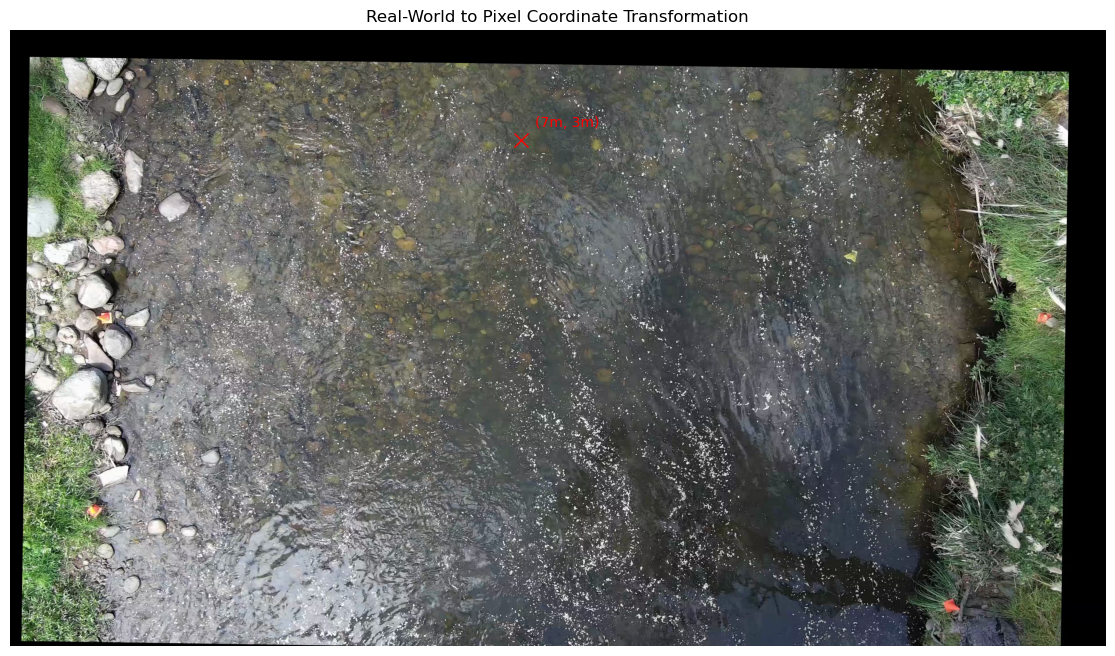

In [19]:
# Example: Convert real-world coordinates to pixel coordinates
# Let's try a point at 7 meters along our reference line
real_world_point = (7, 3)  # 7 meters East, 3 meters North
pix_coordinate = ct.transform_real_world_to_pixel(
    x_rw=real_world_point[0],  # East coordinate in meters
    y_rw=real_world_point[1],  # North coordinate in meters
    transformation_matrix=matrix
)

# Display the results
print("Real-World to Pixel Transformation Example:")
print("-" * 50)
print(f"Input Real-World Coordinates:")
print(f"East: {real_world_point[0]} meters")
print(f"North: {real_world_point[1]} meters")
print("\nTransformed Pixel Coordinates:")
print(f"x: {pix_coordinate[0]:.2f} pixels")
print(f"y: {pix_coordinate[1]:.2f} pixels")

# Visualize the result
plt.figure(figsize=(15, 8))
plt.imshow(img)

# Plot our transformed point
plt.plot(pix_coordinate[0], pix_coordinate[1], 'rx', 
         markersize=10)
plt.annotate(f'(7m, 3m)', (pix_coordinate[0], pix_coordinate[1]), 
             xytext=(10, 10), textcoords='offset points',
                color = 'red')

plt.title('Real-World to Pixel Coordinate Transformation')

plt.axis('off')